## 逻辑回归

In [36]:
# 三大件

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='ticks',context='poster')
# sns.set(style='ticks',context='poster',font_scale=0.5)

In [37]:
filepath = '/Users/joey/Documents/PycharmProjects/mywork/regressionalgorithm/LogiReg_data.txt'
pdData = pd.read_csv(filepath,header=None,names=['Exam 1','Exam 2','Admitted'])
print(pdData.shape)
pdData.head()

(100, 3)


,Exam 1,Exam 2,Admitted
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


In [38]:
positive = pdData[pdData['Admitted'] == 1]
negative = pdData[pdData['Admitted'] == 0]

Text(0, 0.5, 'Exam 2 Score')

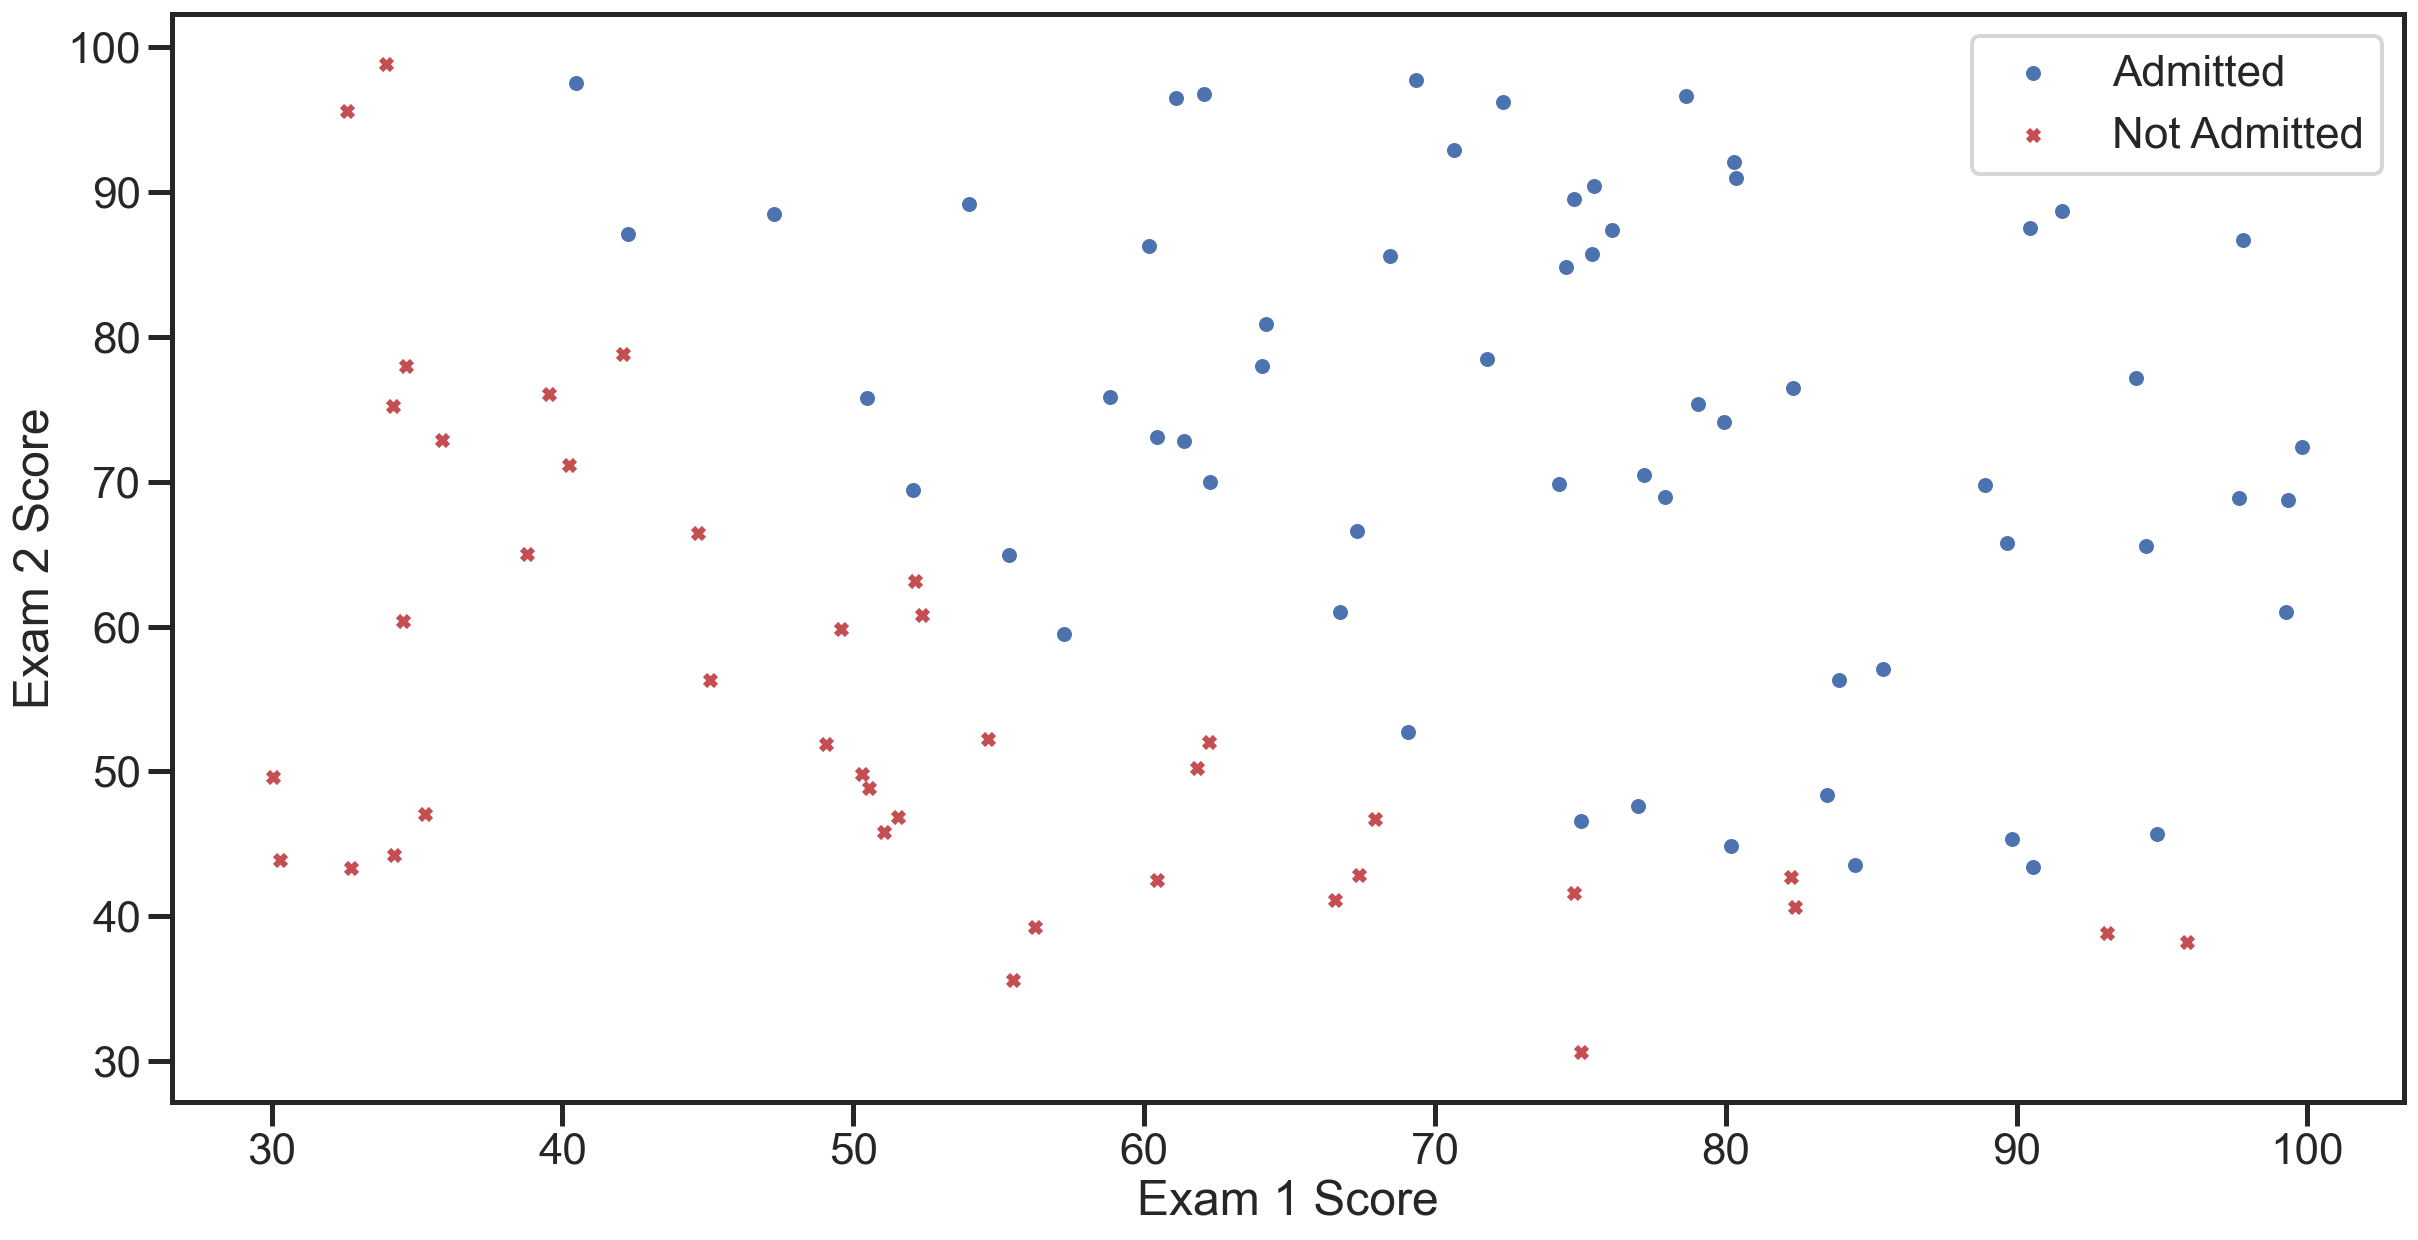

In [39]:
# 最后得出的结果应该是像图里的一条收敛的分界线
fig, ax = plt.subplots(figsize=(20,10))
# ax[0].scatter(positive['Exam 1'],positive['Exam 2'],s=30,c='b',marker='o',label='Admitted')
# ax[1].scatter(negative['Exam 1'],negative['Exam 2'])
ax.scatter(positive['Exam 1'],positive['Exam 2'],s=30,c='b',marker='o',label='Admitted')
ax.scatter(negative['Exam 1'],negative['Exam 2'],s=30,c='r',marker='x',label='Not Admitted')
ax.legend()
ax.set_xlabel('Exam 1 Score')
ax.set_ylabel('Exam 2 Score')

## 建模流程
目标：建立分类器$\theta_0\theta_1\theta_2$
设定阈值，根据阈值判断录取结果

要完成的模块：
* sigmoid 映射到概率的函数
* model 返回预测结果值
* cost 根据参数计算损失
* gradient 计算每个参数的梯度方向
* descent 进行参数更新
* accuracy 计算精度

### sigmoid
$
g(z) = \frac{1}{1+e^{-z}}
$

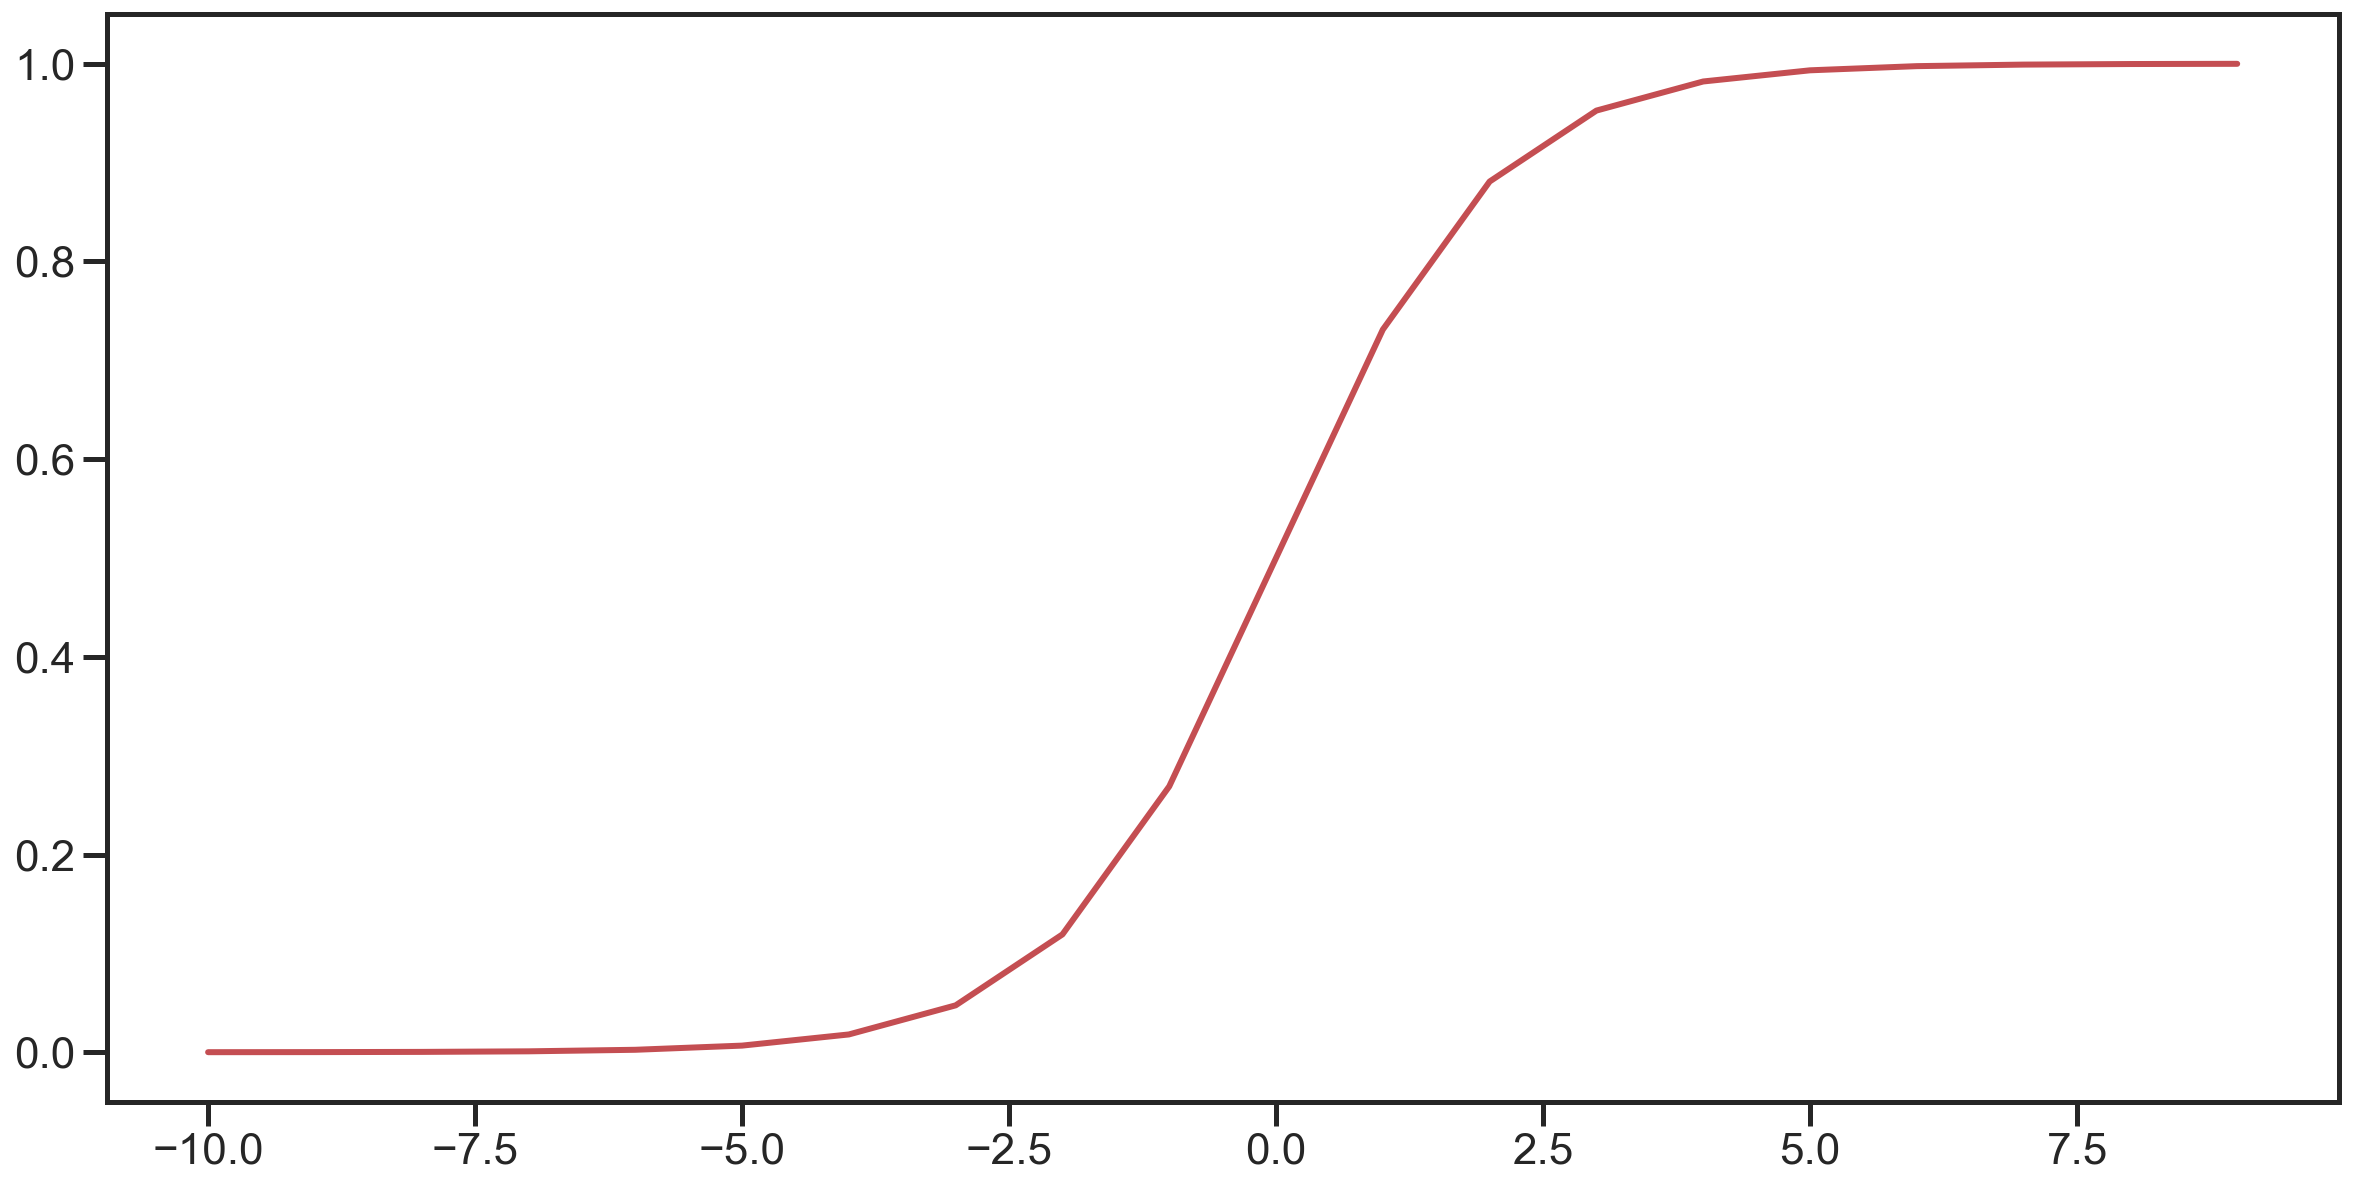

In [40]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

# 测试
fig, ax = plt.subplots(figsize=(20,10))
nums = np.arange(-10,10,step=1)
plt.plot(nums, sigmoid(nums),'r')

### digmoid
* $g:\mathbb{R} \to [0,1]$
* $g(0)=0.5$
* $g(- \infty)=0$
* $g(+ \infty)=1$



In [41]:
# 预测函数
def model(X, theta):
    return sigmoid(np.dot(X, theta.T))


$
\begin{array}{ccc}
\begin{pmatrix}\theta_{0} & \theta_{1} & \theta_{2}\end{pmatrix} & \times & \begin{pmatrix}1\\\
x_{1}\\\
x_{2}
\end{pmatrix}\end{array}=\theta_{0}+\theta_{1}x_{1}+\theta_{2}x_{2}
$

In [42]:
# del pdData['Ones']
pdData.insert(0,'Ones',1)
orig_data = pdData.values # 转为矩阵，as_matrix失效。np.matrix(pdData)
cols = orig_data.shape[1]
theta = np.zeros([1,3]) # 初始值为设为0，后期求梯度得出真正的theta
X = orig_data[:,0:cols-1]
y = orig_data[:,cols-1:cols]
X[:5],y[:5]

(array([[ 1.        , 34.62365962, 78.02469282],
        [ 1.        , 30.28671077, 43.89499752],
        [ 1.        , 35.84740877, 72.90219803],
        [ 1.        , 60.18259939, 86.3085521 ],
        [ 1.        , 79.03273605, 75.34437644]]),
 array([[0.],
        [0.],
        [0.],
        [1.],
        [1.]]))

In [43]:
X.shape, y.shape, theta.shape

((100, 3), (100, 1), (1, 3))

### 损失函数(对数似然函数)
##### 估量模型的预测值f(x)与真实值Y的不一致程度

将对数似然函数去负号
$
D(h_\theta(x), y) = -y\log(h_\theta(x)) - (1-y)\log(1-h_\theta(x))
$
求平均损失
$
J(\theta)=\frac{1}{n}\sum_{i=1}^{n} D(h_\theta(x_i), y_i)
$

In [44]:
def cost(X, y, theta):
    left = np.multiply(-y, np.log(model(X,theta)))
    right = np.multiply(1-y,np.log(1-model(X,theta)))
    return np.sum(left-right)/len(X)
cost(X,y,theta) # 默认0的情况下损失值

0.6931471805599453

### 计算梯度

$
\frac{\partial J}{\partial \theta_j}=-\frac{1}{m}\sum_{i=1}^n (y_i - h_\theta (x_i))x_{ij}
$


In [45]:
def gradient(X, y, theta):
    grad = np.zeros(theta.shape)
    error = (model(X,theta) - y).ravel() #ravel函数降维[,,,,]
    for j in range(len(theta.ravel())):
        term = np.multiply(error,X[:,j])
        grad[0:j] = np.sum(term) / len(X)
    return grad

In [46]:
gradient(X,y,theta)

array([[-11.26284221, -11.26284221, -11.26284221]])

### Gradient descent
#### 比较3中不同梯度下降方法



In [102]:
# 比较3中不同梯度下降方法
STOP_ITER = 0
STOP_COST = 1
STOP_GRAD = 2

def stopCriterion(type, value, threshold):
    # 设定三种不同停止策略
    if type == STOP_ITER:
        return value > threshold # threshold 阈值
    elif type == STOP_COST:
        return abs(value[-1]-value[-2]) < threshold
    elif type == STOP_GRAD:
        return np.linalg.norm(value) < threshold # norm矩阵范数反映了线性映射把一个向量映射为另一个向量，向量的“长度”缩放的比例。

In [103]:
import numpy.random
# 洗牌
def shuffleData(data):
    np.random.shuffle(data) # 洗牌函数
    cols = data.shape[1]
    X = data[:,0:cols-1]
    y = data[:,cols-1:]
    return X, y

In [104]:
import time

def descent(data, theta, batchsize, stopType, thresh, alpha):
    #梯度下降求解
    init_time = time.time()
    i = 0 # 迭代次数
    k = 0 # batch 要选择数据的范围
    X, y = shuffleData(data)
    grad = np.zeros(theta.shape) # 计算的梯度
    costs = [cost(X, y, theta)] # 损失值

    while True:
        grad = gradient(X[k:k+batchsize], y[k:k+batchsize], theta)
        k += batchsize # 取batch数量个数据

        if k >= n:
            k = 0
            X, y = shuffleData(data) # 重新洗牌
        theta = theta - alpha * grad # 参数更新
        costs.append(cost(X, y, theta))
        i += 1

        if stopType == STOP_ITER:       value = i
        elif stopType == STOP_COST:     value = costs
        elif stopType == STOP_GRAD:     value = grad
        if stopCriterion(stopType, value, thresh):      break

    return theta, i-1, costs, grad, time.time() - init_time

In [ ]:
# 测试函数
n=100
descent(orig_data,theta,batchsize=n,stopType=STOP_ITER,thresh=5000,alpha=0.001)

In [108]:
def runExpe(data, theta, batchsize, stopType, thresh, alpha):
    # import pdb;pdb.set_trace();
    theta, iter, costs, grad, dur = descent(data, theta, batchsize, stopType, thresh, alpha)
    name = 'Original' if (data[:,1] > 2).sum() > 1 else 'scaled'
    name += 'data - learning rate:{} - '.format(alpha)
    if batchsize == n:      strDescType = 'Gradient'
    elif batchsize ==1:         strDescType = 'Stochastic'
    else:       strDescType = 'Mini-batch ({})'.format(batchsize)

    name += strDescType + 'descent - Stop:'

    if stopType == STOP_ITER:       strStop = '{} iterations'.format(thresh)
    elif stopType == STOP_COST:     strStop = 'costs change < {}'.format(thresh)
    else: strStop = 'gradient norm < {}'.format(thresh)

    name += strStop

    print('{}\nTheta:{} - Iter:{} - Last cost:{:03.2f} - Duration:{:03.2f}s'.format(
        name, theta, iter, costs[-1], dur))
    fig, ax = plt.subplots(figsize=(12,4))
    ax.plot(np.arange(len(costs)), costs, 'r')
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Cost')
    ax.set_title(name.upper() + '- Error vs. Iteration')
    return theta


### 不同的停止策略

#### 设定迭代次数

Originaldata - learning rate:1e-06 - Gradientdescent - Stop:5000 iterations
Theta:[[0.00515976 0.00515976 0.00515976]] - Iter:5000 - Last cost:0.63 - Duration:1.45s


array([[0.00515976, 0.00515976, 0.00515976]])

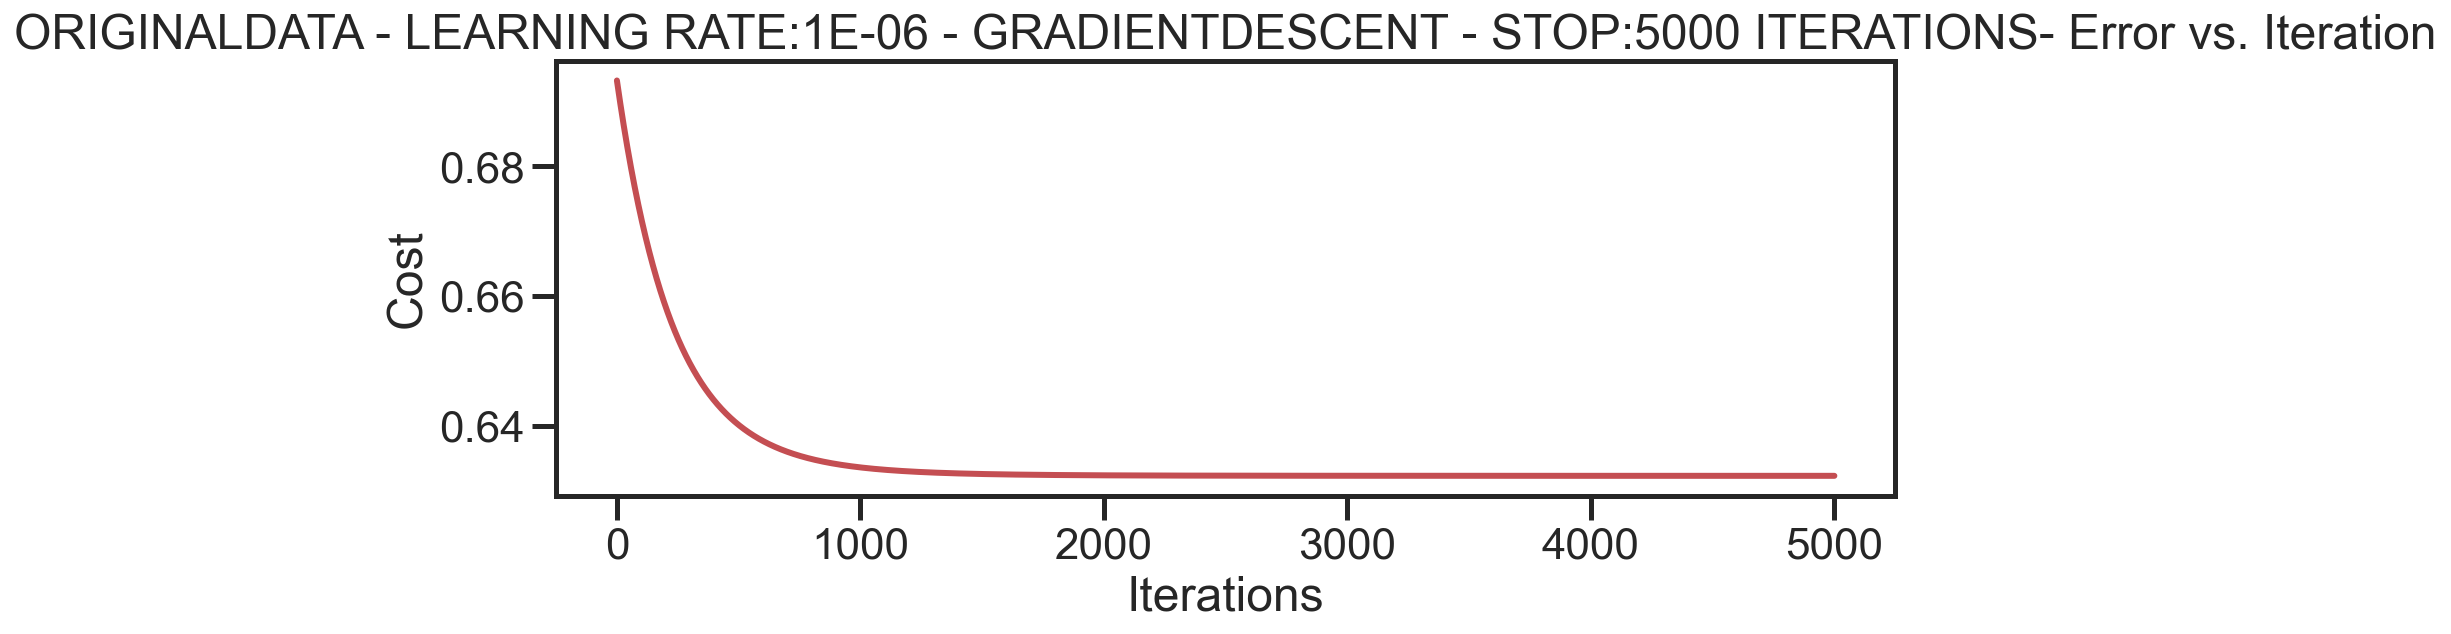

In [109]:
#选择的梯度下降方法是基于所有样本的
n = 100 # 数据大小 100条数据
runExpe(orig_data, theta, batchsize=n, stopType=STOP_ITER, thresh=5000,alpha=0.000001)

#### 根据损失值停止
设定阈值 1E-6, 差不多需要110 000次迭代

Originaldata - learning rate:0.001 - Gradientdescent - Stop:costs change < 1e-06
Theta:[[0.00516064 0.00516064 0.00516064]] - Iter:1186 - Last cost:0.63 - Duration:0.29s


array([[0.00516064, 0.00516064, 0.00516064]])

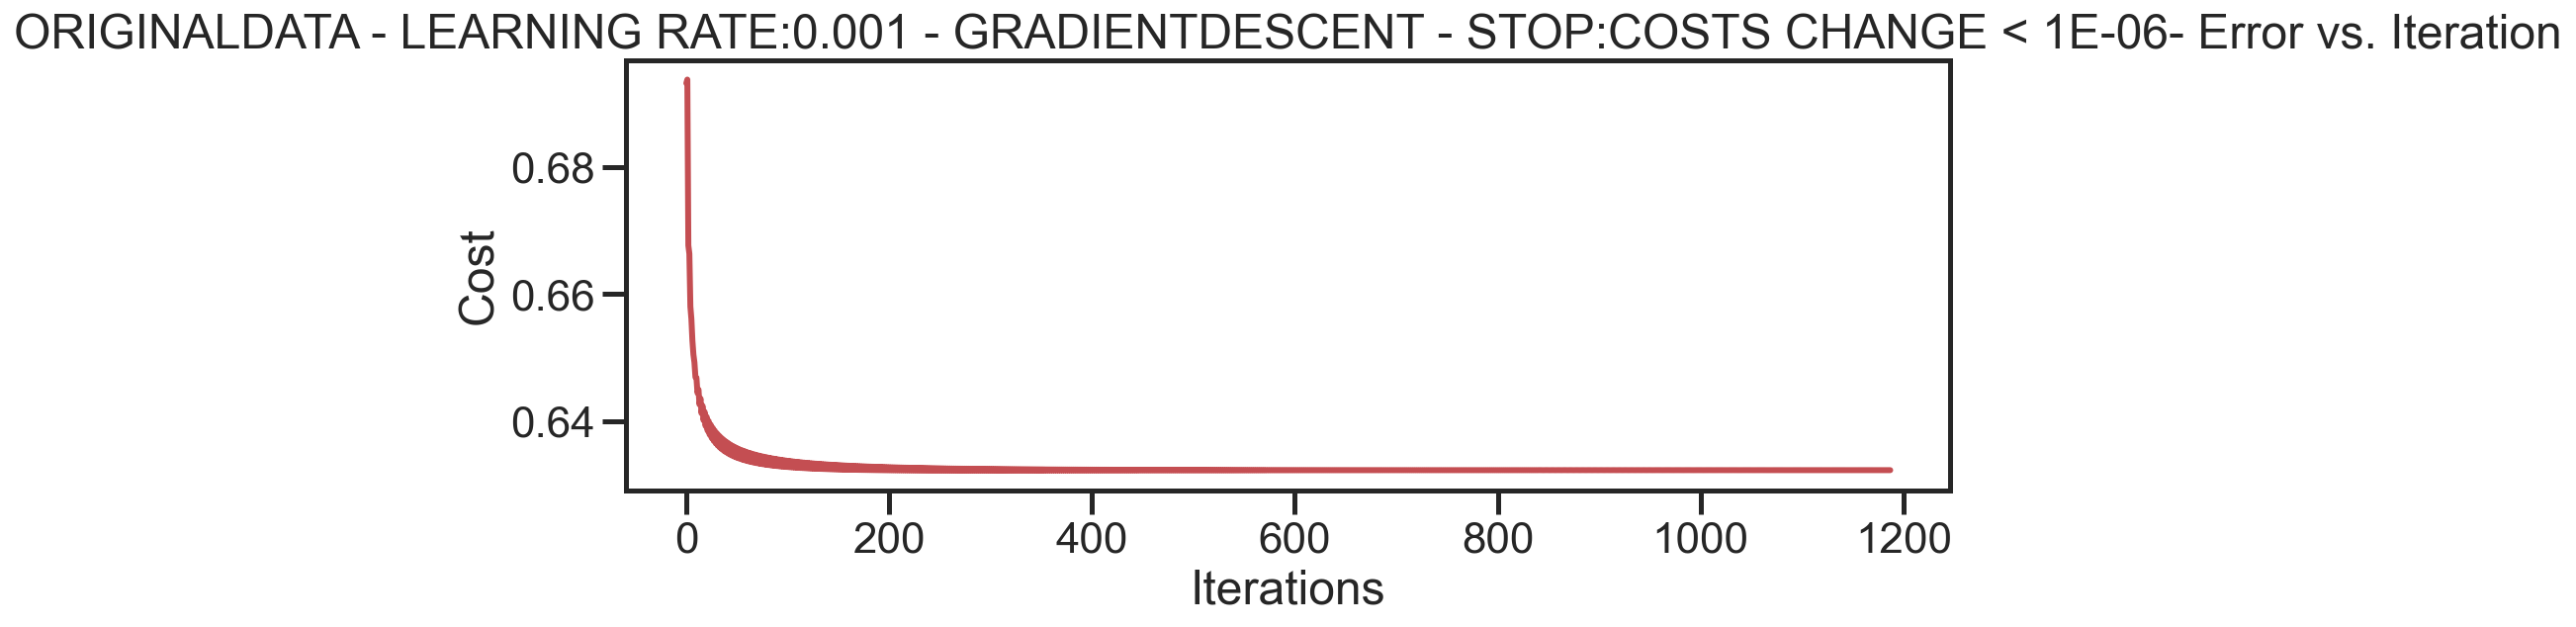

In [110]:
n = 100
runExpe(orig_data, theta, n, STOP_COST, thresh=0.000001, alpha=0.001)


#### 根据梯度变化停止
设定阈值 0.05,差不多需要40 000次迭代

Originaldata - learning rate:0.001 - Gradientdescent - Stop:gradient norm < 0.05
Theta:[[0.00514567 0.00514567 0.00514567]] - Iter:697 - Last cost:0.63 - Duration:0.24s


array([[0.00514567, 0.00514567, 0.00514567]])

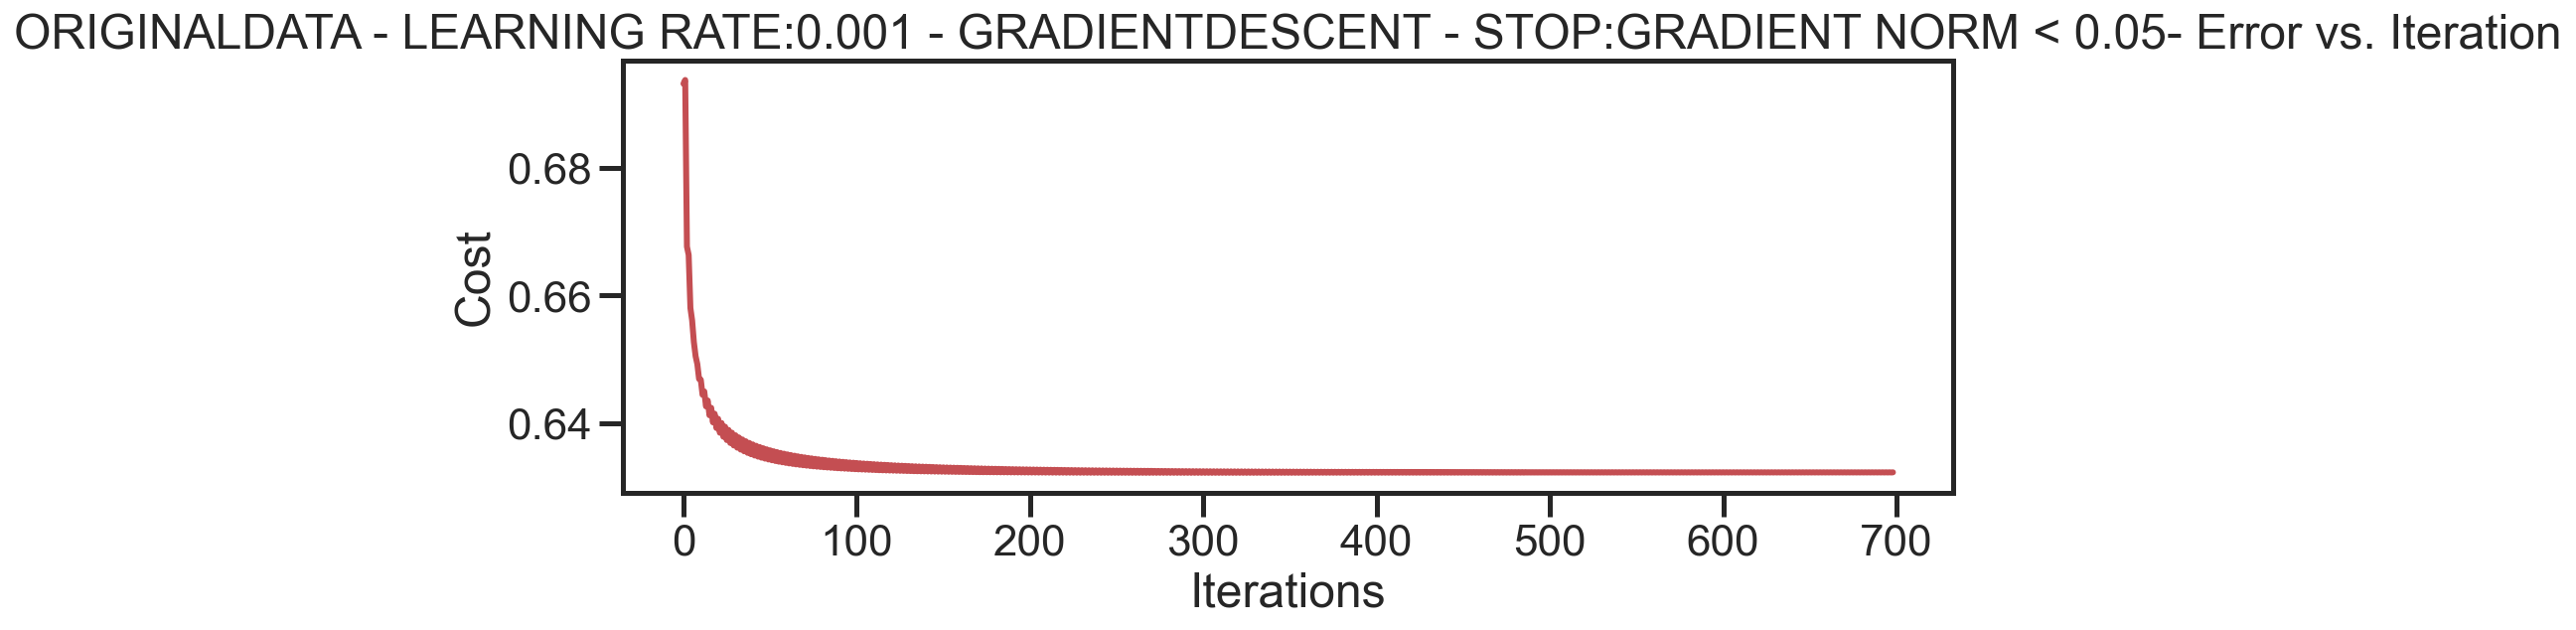

In [111]:
runExpe(orig_data, theta, n, STOP_GRAD, thresh=0.05, alpha=0.001)


### 对比不同的梯度下降方法

#### Stochastic(随机的) descent

Originaldata - learning rate:0.001 - Stochasticdescent - Stop:5000 iterations
Theta:[[-0.02692491 -0.02692491 -0.02692491]] - Iter:5000 - Last cost:2.45 - Duration:0.56s


array([[-0.02692491, -0.02692491, -0.02692491]])

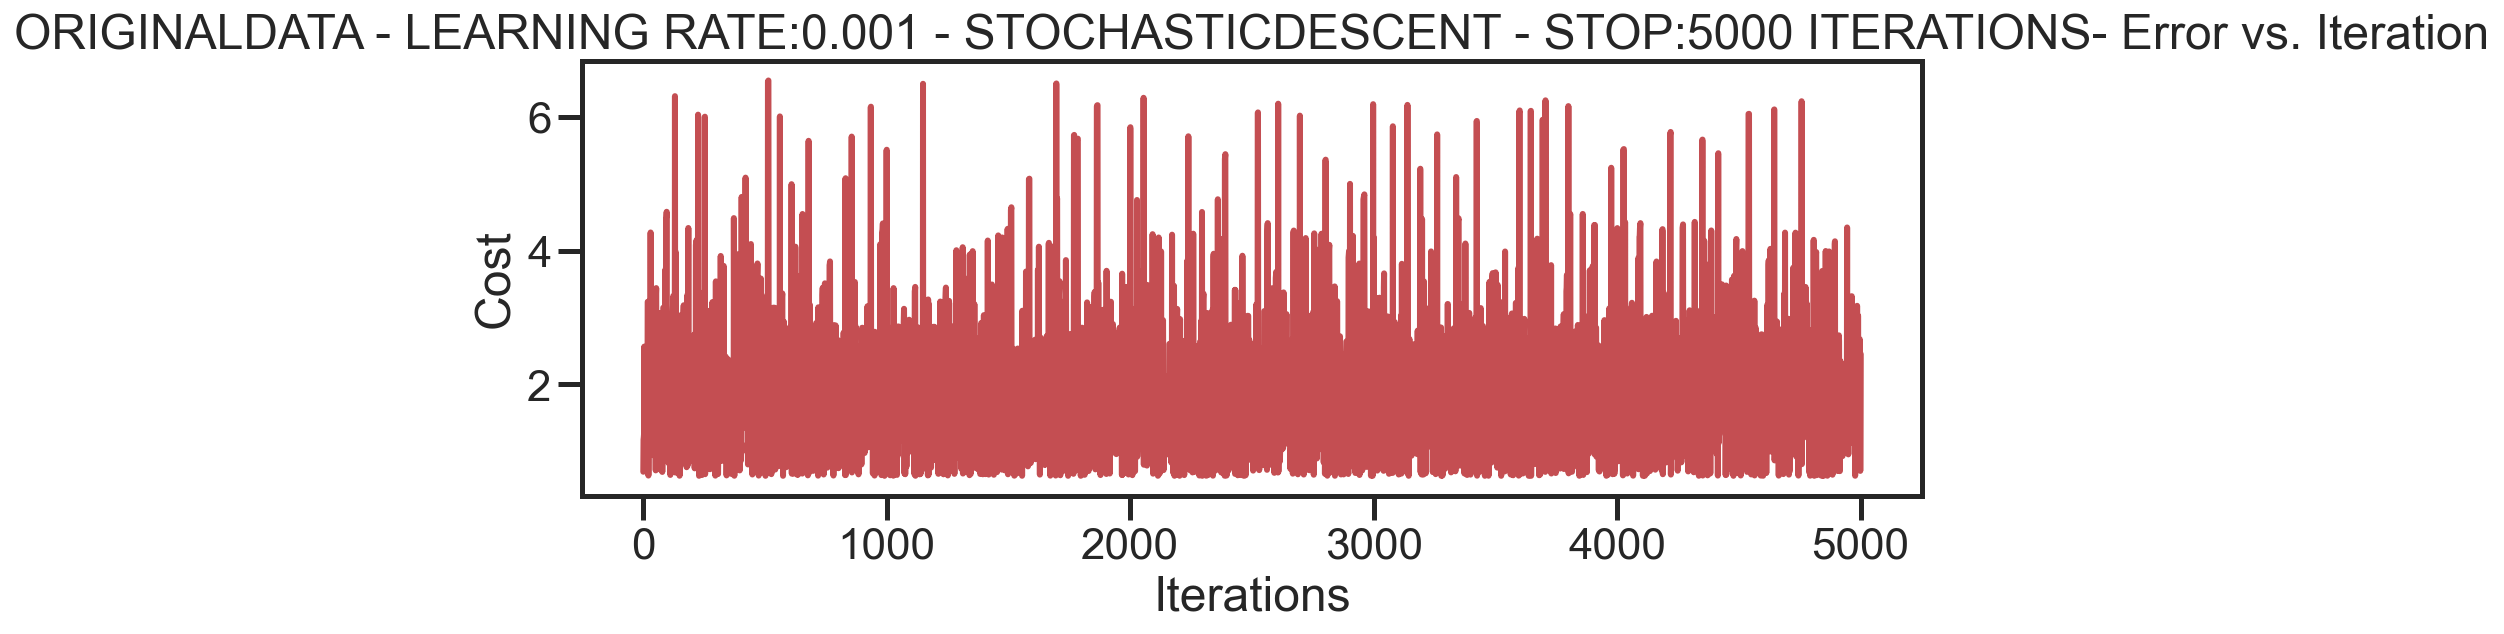

In [112]:
runExpe(orig_data, theta, 1, STOP_ITER, thresh=5000, alpha=0.001)

有点爆炸。。。很不稳定,再来试试把学习率调小一些

Originaldata - learning rate:2e-06 - Stochasticdescent - Stop:15000 iterations
Theta:[[0.00485585 0.00485585 0.00485585]] - Iter:15000 - Last cost:0.63 - Duration:1.62s


array([[0.00485585, 0.00485585, 0.00485585]])

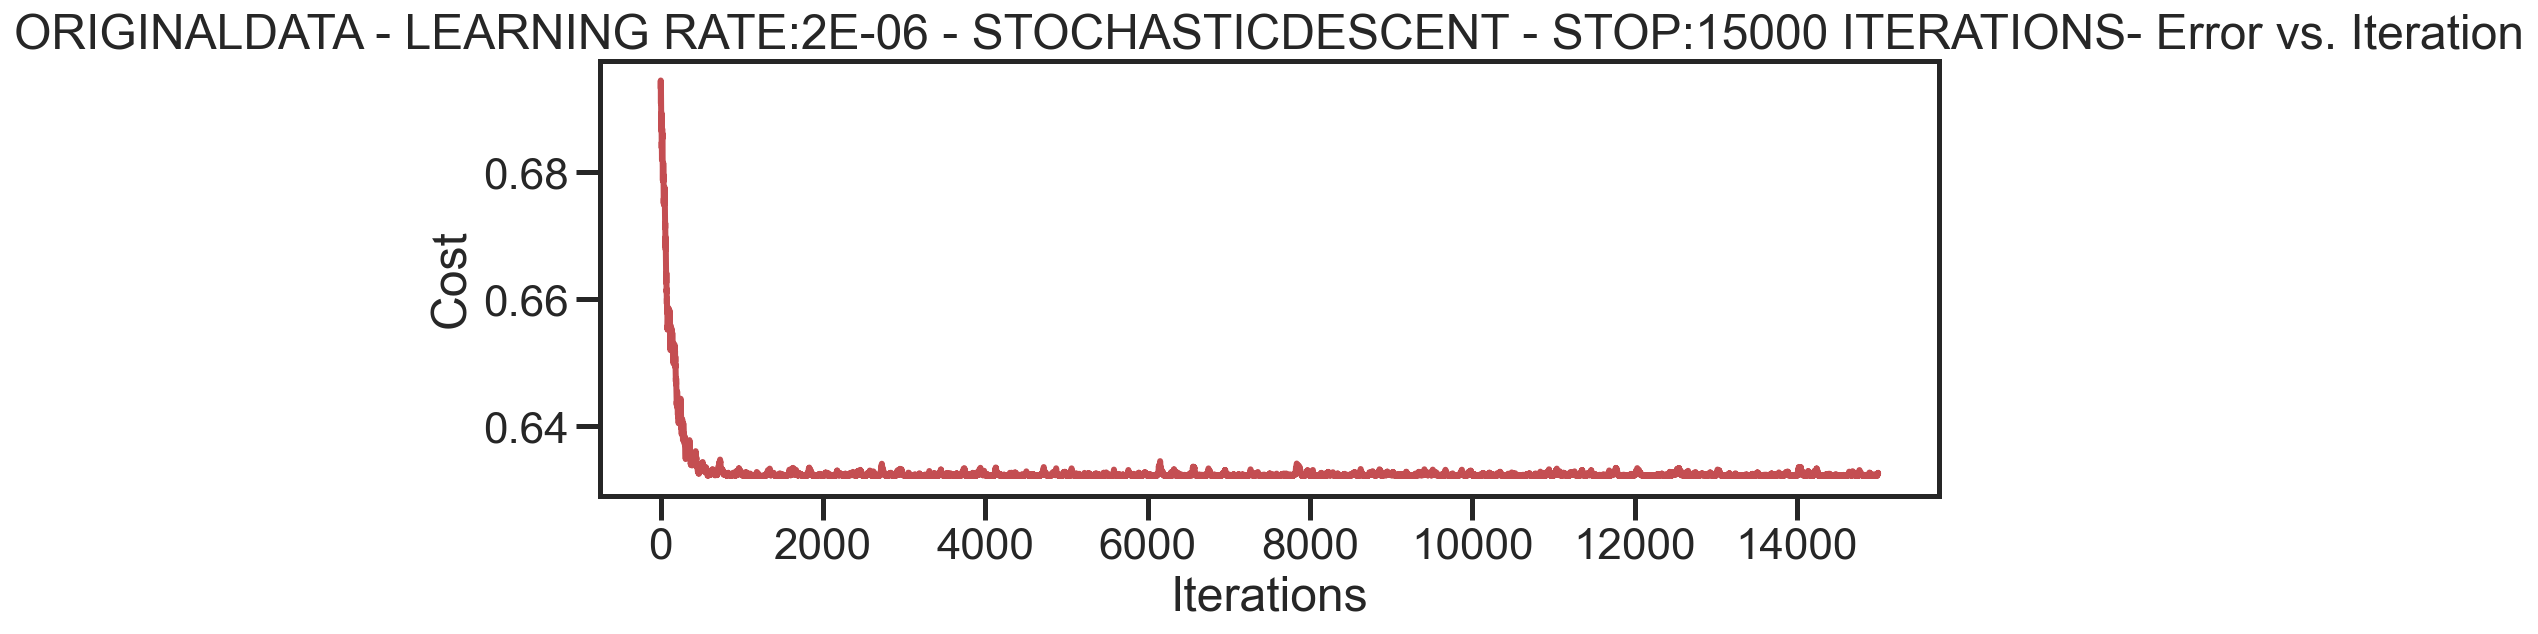

In [113]:
runExpe(orig_data, theta, 1, STOP_ITER, thresh=15000, alpha=0.000002)

速度快，但稳定性差，需要很小的学习率

#### Mini-batch descent

Originaldata - learning rate:0.001 - Mini-batch (16)descent - Stop:15000 iterations
Theta:[[0.01045712 0.01045712 0.01045712]] - Iter:15000 - Last cost:0.68 - Duration:1.85s


array([[0.01045712, 0.01045712, 0.01045712]])

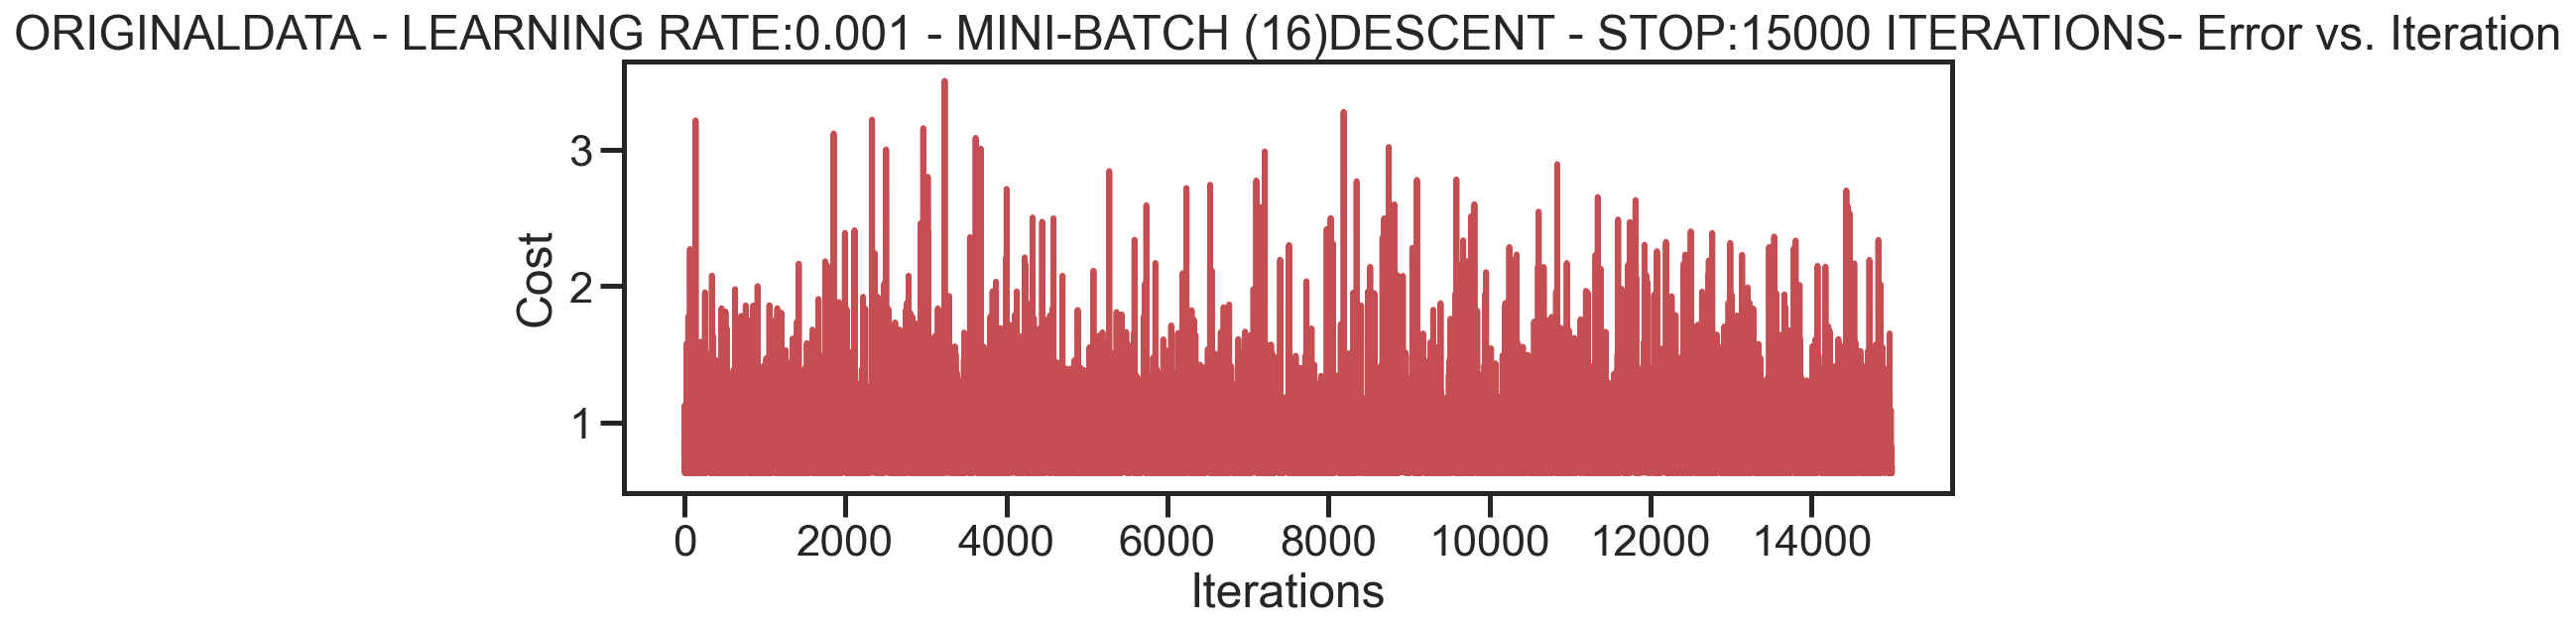

In [114]:
runExpe(orig_data, theta, 16, STOP_ITER, thresh=15000, alpha=0.001)

浮动仍然比较大，我们来尝试下对数据进行标准化
将数据按其属性(按列进行)减去其均值，然后除以其方差。最后得到的结果是，对每个属性/每列来说所有数据都聚集在0附近，方差值为1

scaleddata - learning rate:0.001 - Gradientdescent - Stop:5000 iterations
Theta:[[0.78817619 0.78817619 0.78817619]] - Iter:5000 - Last cost:0.39 - Duration:1.32s


array([[0.78817619, 0.78817619, 0.78817619]])

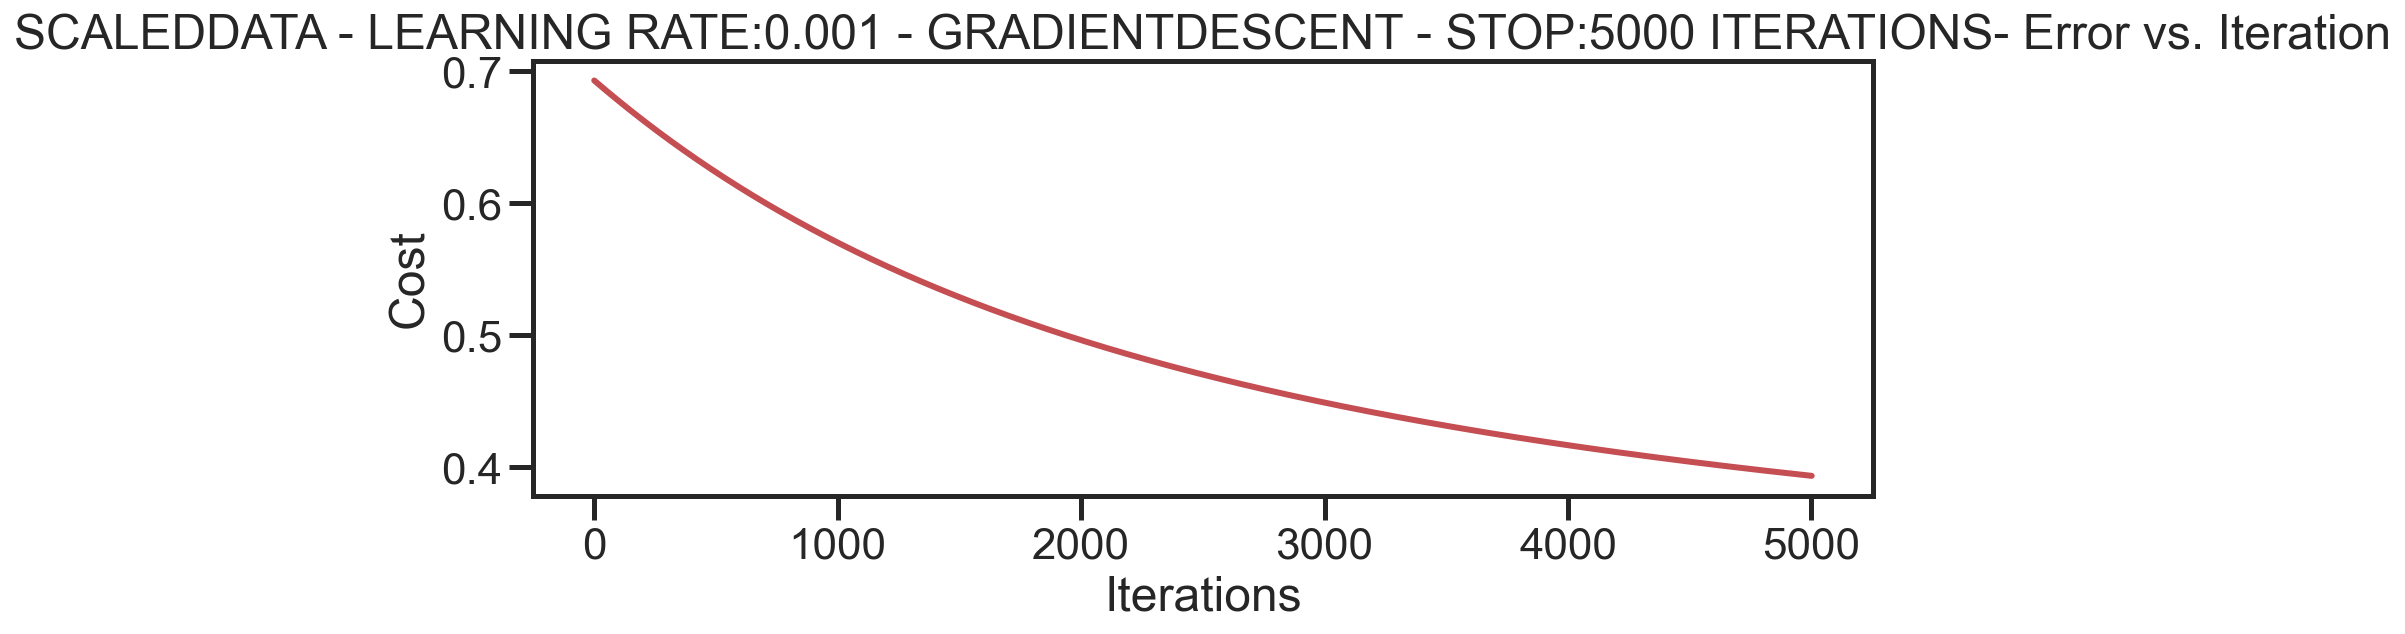

In [115]:
from sklearn import preprocessing as pp
scaled_data = orig_data.copy()
scaled_data[:,1:3] = pp.scale(orig_data[:,1:3])

runExpe(scaled_data, theta, n, STOP_ITER, thresh=5000, alpha=0.001)


它好多了！原始数据，只能达到达到0.61，而我们得到了0.38个在这里！
所以对数据做预处理是非常重要的

In [119]:
runExpe(scaled_data, theta, n, STOP_GRAD, thresh=0.02, alpha=0.001)

/Users/joey/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/joey/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until


KeyboardInterrupt: 

更多的迭代次数会使得损失下降的更多！

scaleddata - learning rate:0.001 - Stochasticdescent - Stop:gradient norm < 0.0004
Theta:[[2.05355136 2.05355136 2.05355136]] - Iter:40 - Last cost:0.30 - Duration:0.01s


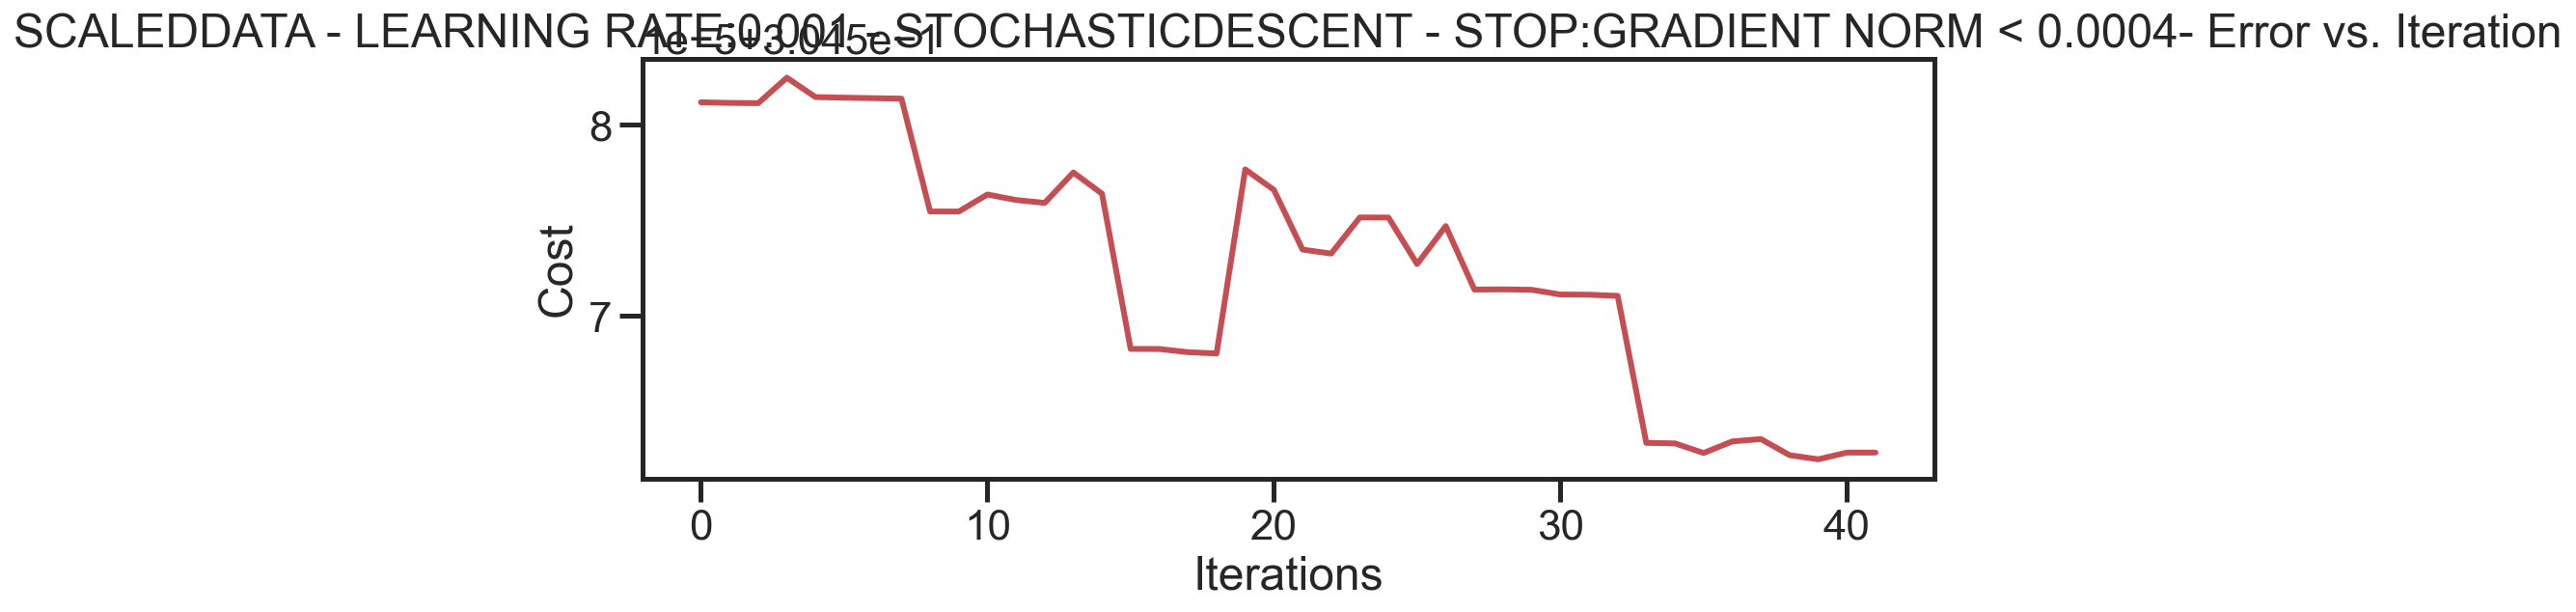

In [122]:
theta = runExpe(scaled_data, theta, 1, STOP_GRAD, thresh=0.002/5, alpha=0.001)


随机梯度下降更快，但是我们需要迭代的次数也需要更多，所以还是用batch的比较合适！！！

scaleddata - learning rate:0.001 - Mini-batch (16)descent - Stop:gradient norm < 0.004
Theta:[[2.05140605 2.05140605 2.05140605]] - Iter:45 - Last cost:0.30 - Duration:0.01s


array([[2.05140605, 2.05140605, 2.05140605]])

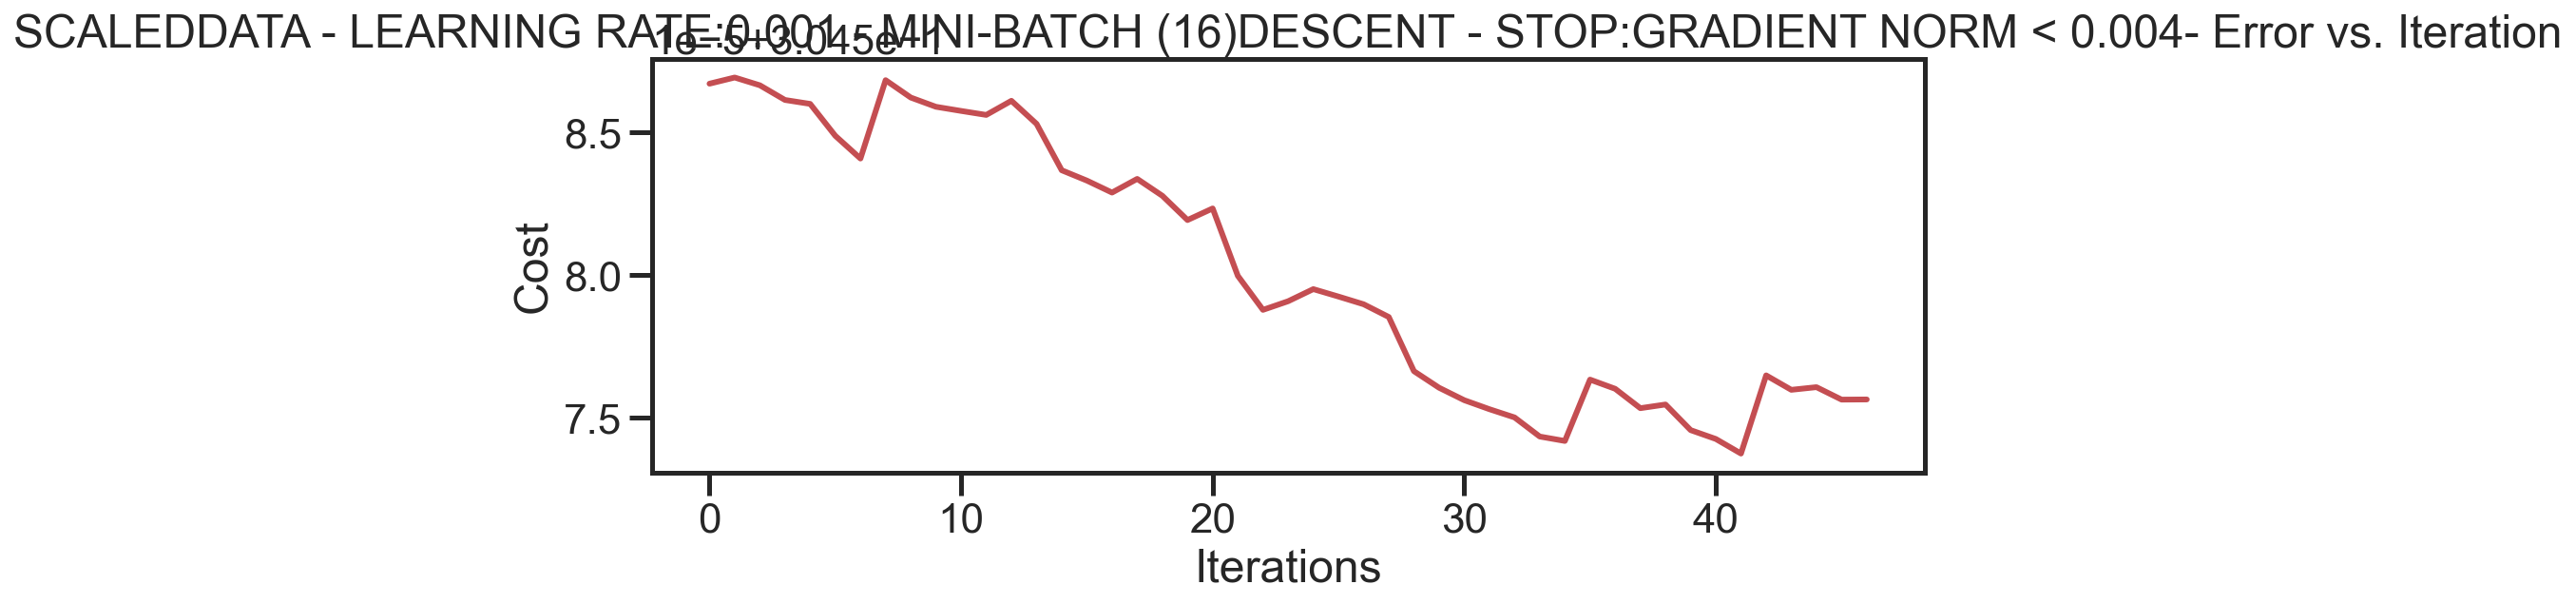

In [118]:
runExpe(scaled_data, theta, 16, STOP_GRAD, thresh=0.002*2, alpha=0.001)


## 精度

In [125]:
# 设定阈值
def predict(X,theta):
    return [1 if x >= 0.5 else 0 for x in model(X,theta)]


In [126]:
scaled_X = scaled_data[:, :3]
y = scaled_data[:, 3]
predictions = predict(scaled_X, theta)
correct = [1 if ((a == 1 and b == 1) or (a == 0 and b == 0)) else 0 for (a, b) in zip(predictions, y)]
accuracy = (sum(map(int, correct)) % len(correct))
print ('accuracy = {0}%'.format(accuracy))


accuracy = 86%


In [128]:
np.log(-2)

/Users/joey/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


nan